### _**Import Library**_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf
from IPython.display import display
from scipy.stats import norm

print("Library berhasil diimpor!")

Library berhasil diimpor!


### **Persiapan Folder**

In [3]:
# Buat Folder Visualisasi
output_folder = 'Visualisasi'
os.makedirs(output_folder, exist_ok=True)
print(f"Folder '{output_folder}' sudah dibuat! Output gambar akan disimpan di folder '/{output_folder}'")

Folder 'Visualisasi' sudah dibuat! Output gambar akan disimpan di folder '/Visualisasi'


### **Download Data**

In [4]:
# Konfigurasi saham
KODE_SAHAM =  'BBCA.JK'
FILE_CSV = 'data.csv'

if not os.path.exists(FILE_CSV):
    print("File belum ada, mengunduh data dari Yahoo Finance...")
    
    df_download = yf.download(
        KODE_SAHAM, 
        period='5y', # Unduh data 5th terakhir
        auto_adjust=True # Koreksi harga kena Dividen/Split biar data bersih
        ) 
    df_download.to_csv(FILE_CSV)
    
    print(f"Download selesai! Data disimpan ke {FILE_CSV}.")
else:
    print(f"File {FILE_CSV} sudah ada.")

File data.csv sudah ada.


> **Keterangan Proses:**
> <br> Output di atas mengonfirmasi sumber data yang digunakan. Jika tercetak **"Download selesai"**, artinya data baru saja diperbarui dari bursa saham. Jika **"File sudah ada"**, simulasi menggunakan dataset yang tersimpan sebelumnya.

## _**1. Data Loading & Initial Inspection**_
Tahap ini memuat dataset historis dari file CSV. Melihat struktur data mentah (*raw data*) untuk mengidentifikasi baris metadata (header tambahan) yang perlu dibersihkan.

In [5]:
# Konfigurasi File
FILE_CSV = 'data.csv'

# Baca data
df = pd.read_csv(FILE_CSV)

display(df.head())
df.info()

,Price,Close,High,Low,Open,Volume
0,Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-12-14,6015.1455078125,6023.965369260905,5993.095854191486,5997.505784915689,179785500
3,2020-12-15,5988.6845703125,6085.703024323453,5825.517170384987,6023.964008134665,164024500
4,2020-12-16,6129.802734375,6129.802734375,6032.7842738309355,6050.423993929856,138674000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   1208 non-null   object
 1   Close   1207 non-null   object
 2   High    1207 non-null   object
 3   Low     1207 non-null   object
 4   Open    1207 non-null   object
 5   Volume  1207 non-null   object
dtypes: object(6)
memory usage: 56.8+ KB


### **Analisis Struktur & Kualitas Data Mentah**

Berdasarkan tampilan sampel data (`head`) dan info teknis (`info`), terdapat 3 masalah struktural akibat format baru *yfinance*:

1.  **Metadata "Sampah":** Baris 0 dan 1 berisi informasi `Ticker` dan `NaN`, bukan data harga. Ini menyebabkan selisih jumlah baris (1208 vs 1207) pada `df.info()`.
2.  **Salah Label Kolom:** Kolom pertama bernama `Price`, padahal isinya adalah **Tanggal** (*Date*).
3.  **Tipe Data Invalid (Object):** Karena adanya teks di baris awal, Python membaca seluruh angka sebagai **Teks** (*Dtype: object*). Simulasi matematis tidak bisa dilakukan sebelum ini diperbaiki.

**Rencana Perbaikan (*Cleaning*):**
Tahap selanjutnya akan menghapus 2 baris teratas, memperbaiki nama kolom, dan memaksa konversi tipe data menjadi numerik.

## _**2. Data Cleaning & Preprocessing**_
Data mentah dari Yahoo Finance memiliki baris metadata (*Ticker* dan *Date*) yang tidak diperlukan. Tahap ini meliputi:
1. Menghapus 2 baris teratas (metadata).
2. Mereset indeks tabel.
3. Mengubah tipe data dari *Object* (Teks) menjadi *Float* (Angka) agar bisa dihitung secara statistik.

In [6]:
# Buat salinan data asli
df_clean = df.copy()

# 1. Hapus Baris Metadata (Ticker & Date)
if df_clean.iloc[0, 0] == 'Ticker':
    df_clean = df_clean.iloc[2:]
    print("(1) Berhasil menghapus 2 baris metadata (Ticker & Date)!")
    
# 2. Reset Index
df_clean = df_clean.reset_index(drop=True)

# 3a. Perbaiki Nama Kolom
if 'Price' in df_clean.columns:
    df_clean = df_clean.rename(columns={'Price': 'Date'})
    print("(2) Rename kolom 'Price' menjadi 'Date'!")
    
# 3b. Konversi Tipe Data kolom Date jdi datetime
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    print("(3) Berhasil mengonversi kolom 'Date' menjadi tipe datetime!")
    
# 3c. Ubah Kolom Angka jadi Numerik
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        print(f"(4) Berhasil mengonversi kolom '{col}' menjadi tipe numerik!")
        
display(df_clean.head())
display(df_clean.describe())

data_harga = df_clean['Close']
print(f">> Data siap! Jumlah baris valid {len(data_harga)}.")

(1) Berhasil menghapus 2 baris metadata (Ticker & Date)!
(2) Rename kolom 'Price' menjadi 'Date'!
(3) Berhasil mengonversi kolom 'Date' menjadi tipe datetime!
(4) Berhasil mengonversi kolom 'Open' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'High' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Low' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Close' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Volume' menjadi tipe numerik!


,Date,Close,High,Low,Open,Volume
0,2020-12-14,6015.145508,6023.965369,5993.095854,5997.505785,179785500
1,2020-12-15,5988.684570,6085.703024,5825.517170,6023.964008,164024500
2,2020-12-16,6129.802734,6129.802734,6032.784274,6050.423994,138674000
3,2020-12-17,6116.572754,6173.901842,6015.144366,6143.032333,91920000
4,2020-12-18,5997.504883,6116.572994,5957.815512,6116.572994,147238500


,Date,Close,High,Low,Open,Volume
count,1206,1206.000000,1206.000000,1206.000000,1206.000000,1.206000e+03
mean,2023-06-10 01:51:02.686567168,7867.843945,7939.005114,7801.477414,7870.182375,9.255806e+07
min,2020-12-14 00:00:00,5330.322754,5375.040446,5281.133534,5366.096478,1.065390e+07
25%,2022-03-08 06:00:00,6835.398682,6901.606975,6764.940832,6833.273505,5.822042e+07
50%,2023-06-06 12:00:00,8117.104492,8199.964844,8049.010249,8135.907950,7.739455e+07
75%,2024-09-09 18:00:00,8741.198242,8818.569568,8652.259279,8742.208983,1.064375e+08
max,2025-12-12 00:00:00,10500.997070,10500.997070,10333.171875,10453.046259,7.564316e+08
std,NaN,1288.344989,1295.697261,1281.143131,1286.983457,6.517613e+07


>> Data siap! Jumlah baris valid 1206.


### **Deskripsi Dataset (OHLCV)**

Data yang digunakan terdiri dari variabel standar pasar saham (*OHLCV*):
* **Date:** Tanggal transaksi perdagangan bursa (Hari kerja).
* **Open:** Harga pembukaan saham pada awal sesi perdagangan (pukul 09.00 WIB).
* **High:** Harga tertinggi yang dicapai saham pada hari tersebut.
* **Low:** Harga terendah yang dicapai saham pada hari tersebut.
* **Close:** Harga penutupan pada akhir sesi perdagangan (pukul 16.00 WIB). Variabel ini digunakan sebagai acuan utama dalam perhitungan *return* dan volatilitas.
* **Volume:** Jumlah lembar saham yang diperdagangkan. Menunjukkan likuiditas dan aktivitas pasar.

> **Pemilihan Data Harga**
> <br> Cuma ambil kolom **`Close`** (Harga Penutupan) sebagai data utama. 
> <br> Alasannya: Harga Close adalah nilai **final** yang disepakati pasar hari itu. Ini standar wajib analis saham buat ngitung untung/rugi, jadi simulasi bakal valid.

## _**3. Analisis Statistik Data Historis**_
Untuk membangun simulasi Monte Carlo berbasis *Geometric Brownian Motion* (GBM), diperlukan dua parameter utama yang diestimasi dari data historis:

1.  **Logarithmic Returns ($R_t$):**
    Digunakan menggantikan *simple returns* karena harga saham diasumsikan mengikuti distribusi log-normal (Hull, 2018). Rumus perhitungannya:
    $$R_t = \ln\left(\frac{S_t}{S_{t-1}}\right)$$

2.  **Volatilitas ($\sigma$):**
    Dihitung dari standar deviasi (*standard deviation*) data *log returns*. Ini merepresentasikan risiko atau "goyangan" harga saham.

3.  **Drift ($\mu_{gbm}$):**
    Ini adalah tren pergerakan harga jangka panjang. Dalam model GBM, rata-rata aritmatika ($\mu$) harus disesuaikan dengan varians ($\sigma^2$) agar tidak bias (Ito's Lemma).
    Rumus Drift yang digunakan:
    $$\text{Drift} = \mu - \frac{1}{2}\sigma^2$$

*Referensi: Hull, J. C. (2018). Options, Futures, and Other Derivatives.*

Harga Terakhir (Start): Rp 8,000.00
Rata-rata Return (u):   0.000237
Volatilitas (stdev):    0.014536
Drift (Tren Murni):     0.000131


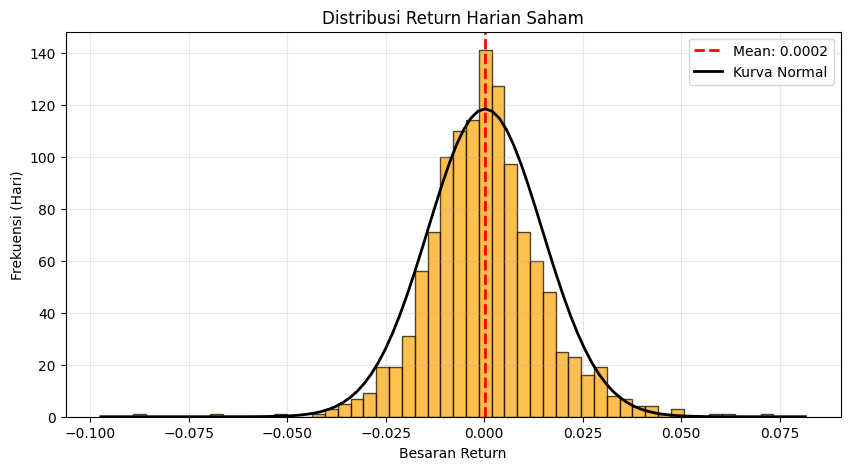

In [7]:
data_harga = df_clean['Close']

# 1. Hitung Return Harian (Log Returns)
# Rumus: ln(Harga Hari Ini / Harga Kemarin)
log_returns = np.log(1 + data_harga.pct_change())

# 2. Hitung Komponen Monte Carlo
u = log_returns.mean()      # Rata-rata return harian
var = log_returns.var()     # Variansi (Kuadrat dari volatilitas)
stdev = log_returns.std()   # Volatilitas (Standard Deviation)

# 3. Hitung Drift (Arah Tren Murni)
# Rumus Drift = Mean - (0.5 * Variansi)
drift = u - (0.5 * var) # Rumus Ito's Lemma

print(f"Harga Terakhir (Start): Rp {data_harga.iloc[-1]:,.2f}")
print(f"Rata-rata Return (u):   {u:.6f}")
print(f"Volatilitas (stdev):    {stdev:.6f}")
print(f"Drift (Tren Murni):     {drift:.6f}")

# Visualisasi
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title(f"Distribusi Return Harian Saham")
plt.xlabel("Besaran Return")
plt.ylabel("Frekuensi (Hari)")

plt.axvline(u, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {u:.4f}')

# Overlay Kurva Normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, u, stdev)
plt.plot(x, p * len(log_returns) * (xmax - xmin) / 50, 'k', linewidth=2, label='Kurva Normal')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### **Intepretasi Histogran**

Grafik diatas berfungsi untuk memverifikasi apakah data saham BBCA cocok disimulasikan dengan metode *Geometric Brownian Motion* (GBM).

1.  **Bentuk Lonceng (*Bell Curve*):**
    Terlihat bahwa mayoritas batang histogram berkumpul di area tengah (sekitar rata-rata/mean). Ini menunjukkan bahwa sebagian besar pergerakan harga harian BBCA cenderung stabil dan wajar. Pergerakan ekstrem (lonjakan tinggi atau penurunan tajam) berada di bagian ekor (*tails*) dan frekuensinya sangat jarang.

2.  **Kesesuaian dengan Distribusi Normal:**
    Garis lengkung hitam pada grafik merepresentasikan kurva Distribusi Normal yang ideal. Karena pola data historis (batang oranye) mengikuti pola garis tersebut dengan cukup presisi, maka dapat disimpulkan bahwa data return saham ini **berdistribusi normal**.

**Kesimpulan:**
Syarat utama metode Monte Carlo terpenuhi. Data historis ini valid untuk digunakan sebagai dasar perhitungan probabilitas harga di masa depan.

## **4. Simulasi Monte Carlo (*Geometric Brownian Motion*)**
Simulasi dilakukan dengan membangkitkan ribuan skenario pergerakan harga masa depan menggunakan model *Geometric Brownian Motion* (GBM). Model ini dipilih karena memisahkan komponen tren pasti (*deterministic*) dan komponen acak (*stochastic*).

Persamaan matematis untuk memprediksi harga saham hari esok ($S_{t+1}$) adalah:

$$S_{t+1} = S_t \times e^{(\text{Drift} \times \Delta t) + (\sigma \times Z \times \sqrt{\Delta t})}$$

Dimana:
* $S_t$: Harga saham hari sebelumnya.
* $\text{Drift}$: Tren rata-rata arah saham ($\mu - 0.5\sigma^2$).
* $\sigma$: Volatilitas historis.
* $Z$: Bilangan acak berdistribusi normal standar ($Z \sim N(0,1)$).
* $\Delta t$: Perubahan waktu (1 hari).

Komponen $Z$ (Z-Score) akan berubah-ubah secara acak di setiap iterasi, menciptakan variasi skenario yang berbeda-beda.

🚀 Memulai simulasi: 1000 skenario untuk 30 hari ke depan...
✅ Simulasi Selesai!


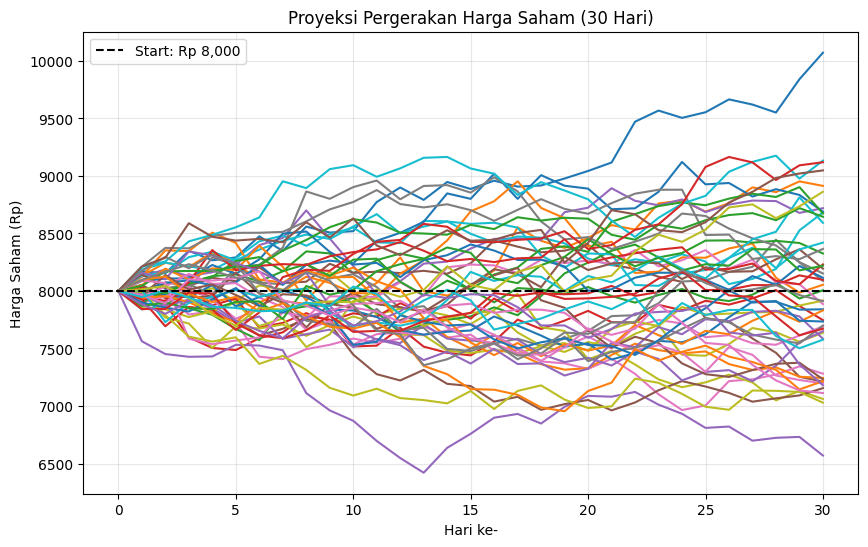

In [8]:
from scipy.stats import norm

# --- 1. KONFIGURASI SIMULASI ---
t_intervals = 31    # 30 Hari + 1 Hari Start (Hari ke-0)
iterations = 1000   # Jumlah skenario (Mobil Virtual)

# Ambil harga terakhir (Close) sebagai titik Start
S0 = data_harga.iloc[-1]

# Siapkan wadah kosong (Matrix) untuk menyimpan semua kemungkinan harga
# Ukuran: (31 Baris Hari) x (1000 Kolom Skenario)
price_list = np.zeros((t_intervals, iterations))

# Set hari pertama (Hari ke-0) semua sama dengan harga terakhir saat ini
price_list[0] = S0

print(f"🚀 Memulai simulasi: {iterations} skenario untuk {t_intervals-1} hari ke depan...")

# --- 2. LOOPING INTI MONTE CARLO ---
for t in range(1, t_intervals):
    # a. Buat bilangan acak (Z-Score) untuk 1000 skenario sekaligus
    Z = norm.ppf(np.random.rand(iterations))
    
    # b. Hitung Return Harian (Rumus GBM)
    daily_return = np.exp(drift + stdev * Z)
    
    # c. Hitung Harga Hari Ini = Harga Kemarin * Return
    price_list[t] = price_list[t-1] * daily_return

print("✅ Simulasi Selesai!")

# --- 3. VISUALISASI PERGERAKAN HARGA (Spaghetti Plot) ---
plt.figure(figsize=(10, 6))

# Kita plot 50 skenario saja biar grafik tidak terlalu berat/penuh
plt.plot(price_list[:, :50]) 

plt.title(f"Proyeksi Pergerakan Harga Saham ({t_intervals-1} Hari)")
plt.xlabel("Hari ke-")
plt.ylabel("Harga Saham (Rp)")

# Tampilkan Garis Start
plt.axhline(y=S0, color='black', linestyle='--', label=f'Start: Rp {S0:,.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **5. Analisis Probabilitas & Kesimpulan Akhir**
Setelah menjalankan 1.000 iterasi, kita mengambil data harga pada **hari terakhir (Hari ke-30)** dari seluruh skenario untuk dianalisis distribusinya.

Kita menggunakan **Confidence Interval 90%** untuk menentukan rentang prediksi yang realistis:
* **Batas Bawah (5th Percentile):** Level support kuat (Skenario Pessimistic).
* **Batas Atas (95th Percentile):** Level resistance kuat (Skenario Optimistic).
* **Mean (Rata-rata):** Target harga yang paling moderat/mungkin terjadi.

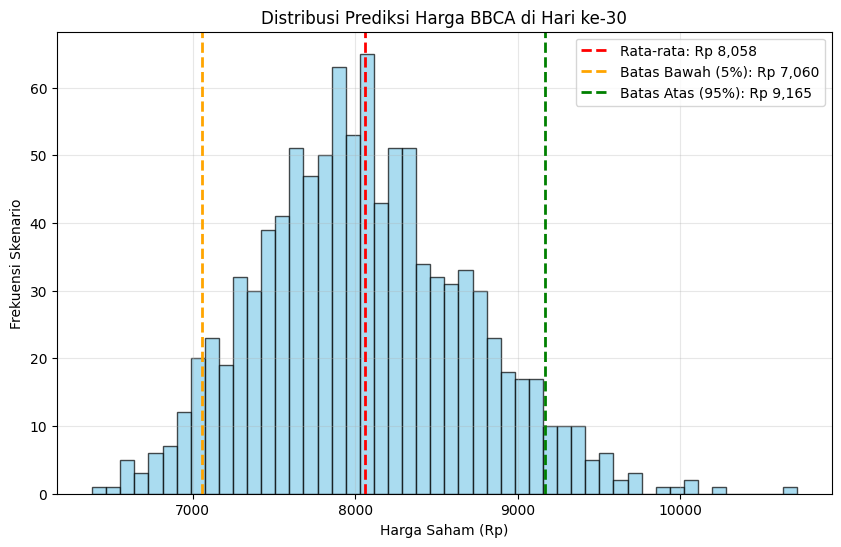


KESIMPULAN PREDIKSI (Confidence Level 90%)
Dalam 30 hari ke depan, harga BBCA diprediksi bergerak antara:
🔻 SUPPORT (Paling Sial)  : Rp 7,060
🔺 RESIST (Paling Untung) : Rp 9,165
--------------------------------------------------
⚖️ TARGET PRICE (Mean)    : Rp 8,058


In [9]:
# 1. Ambil harga pada hari terakhir (hari ke-30) dari semua 1000 skenario
harga_akhir = price_list[-1]

# 2. Hitung Statistik Ringkas
mean_akhir = np.mean(harga_akhir)
q5 = np.percentile(harga_akhir, 5)   # Batas Bawah (Skenario Buruk/Pessimistic)
q95 = np.percentile(harga_akhir, 95) # Batas Atas (Skenario Untung/Optimistic)

# 3. VISUALISASI HISTOGRAM (Distribusi Probabilitas)
plt.figure(figsize=(10, 6))

# Gambar Histogram (Gunung Biru)
plt.hist(harga_akhir, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Garis Rata-rata (Merah Putus-putus)
plt.axvline(mean_akhir, color='red', linestyle='dashed', linewidth=2, label=f'Rata-rata: Rp {mean_akhir:,.0f}')

# Garis Confidence Interval (Zona Aman 90%)
plt.axvline(q5, color='orange', linestyle='--', linewidth=2, label=f'Batas Bawah (5%): Rp {q5:,.0f}')
plt.axvline(q95, color='green', linestyle='--', linewidth=2, label=f'Batas Atas (95%): Rp {q95:,.0f}')

plt.title(f"Distribusi Prediksi Harga BBCA di Hari ke-{t_intervals-1}")
plt.xlabel("Harga Saham (Rp)")
plt.ylabel("Frekuensi Skenario")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. CETAK KESIMPULAN TEKS
print("\n" + "="*50)
print(f"KESIMPULAN PREDIKSI (Confidence Level 90%)")
print("="*50)
print(f"Dalam {t_intervals-1} hari ke depan, harga BBCA diprediksi bergerak antara:")
print(f"🔻 SUPPORT (Paling Sial)  : Rp {q5:,.0f}")
print(f"🔺 RESIST (Paling Untung) : Rp {q95:,.0f}")
print("-" * 50)
print(f"⚖️ TARGET PRICE (Mean)    : Rp {mean_akhir:,.0f}")
print("="*50)

### Interpretasi Hasil Simulasi (Confidence Interval)

Untuk mendapatkan rentang prediksi yang realistis, digunakan **Confidence Level 90%** dengan mengabaikan pencilan ekstrem (*outliers*):

1.  **Persentil 5% (Batas Pesimis):**
    Menunjukkan batas bawah risiko yang wajar. Terdapat probabilitas 95% bahwa harga saham **tidak akan jatuh** di bawah titik ini dalam kondisi pasar normal.

2.  **Persentil 95% (Batas Optimis):**
    Menunjukkan potensi keuntungan maksimal yang realistis. Terdapat probabilitas 95% bahwa harga saham akan berada di bawah titik ini (hanya 5% peluang harga melonjak lebih tinggi).

**Kesimpulan:**
Dengan tingkat keyakinan 90%, investor dapat mengekspektasikan harga saham BBCA pada 30 hari mendatang akan berada di dalam rentang area tersebut.